# Load the entire MNIST digit dataset

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
import numpy as np
import datetime as dt
from scipy import stats
from sklearn.svm import SVC
import time
from sklearn.metrics import accuracy_score

In [2]:
# ! pip install python-mnist
from mnist import MNIST

mndata = MNIST('samples')
X_train, y_train = mndata.load_training()

X_test, y_test = mndata.load_testing()

In [3]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [4]:
X_train.shape

(60000, 784)

# Choose two digit classes (e.g 7s and 3s) from the training data, and plot some of the examples.

In [5]:
# prune training and testing data sets so they contain only
# 0 and 1
def get_data(X, y, digit_list):
    mask = []
    for label in y:
        to_append = False
        for digit in digit_list:
            if label == digit:
                to_append = True
        mask.append(to_append)
    return X[mask,:], y[mask]
X_train01, y_train01 = get_data(X_train, y_train, [0,1])
X_test01, y_test01 = get_data(X_test, y_test, [0,1])

In [6]:
# validation set split
X_train01, X_val01, y_train01, y_val01 = model_selection.train_test_split(X_train01, 
                                                                  y_train01, 
                                                                  test_size=.25)

print('Shape of training features:', X_train01.shape)
print('Shape of training labels:', y_train01.shape)
print('Shape of val features:', X_val01.shape)
print('Shape of val labels:', y_val01.shape)
print('Shape of testing features:', X_test01.shape)
print('Shape of testing labels:', y_test01.shape)

Shape of training features: (9498, 784)
Shape of training labels: (9498,)
Shape of val features: (3167, 784)
Shape of val labels: (3167,)
Shape of testing features: (2115, 784)
Shape of testing labels: (2115,)



Plotting some examples ...


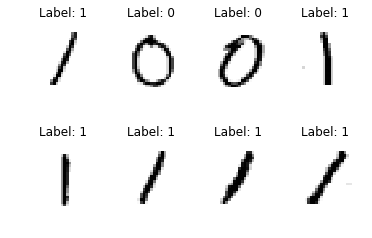

In [7]:
# plotting some examples
print('\nPlotting some examples ...')
images_and_labels = list(zip(X_train01,y_train01))
for index, (image, label) in enumerate(images_and_labels[:8]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(np.reshape(image,(28,28)), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Label: %i' % label)

Because the RBF kernel involves exponentials, and exponentials with large number can be unstable, I normalized the data. Because a lot of features in the original data have the same value (i.e., 0), the scheme of subtracting the mean and divided by the standard deviation fails because the std of those features are 0 and we cannot divide by 0. Therefore, we ignore these features by setting the `nan` in the resulted normalized data to 0. We can do this because features which are all 0 contribute nothing to the model and the decision. This can be done by `np.nan_to_num`.

In [103]:
# Normalizing data
mean_train = np.mean(X_train01,axis=0)
std_train = np.std(X_train01,axis=0)
X_train01_normalized = np.nan_to_num((X_train01 - mean_train)/std_train)
X_val01_normalized = np.nan_to_num((X_val01 - mean_train)/std_train)
X_test01_normalized = np.nan_to_num((X_test01 - mean_train)/std_train)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


# Train a support vector classifier using each of the following kernels:

(**#overfitting**) In all the three sections corresponding to the three kernels, I used the validation set approach for tuning the parameters (as opposed to use cross validation). This is because our data is large enough. The reason we would want to use cross validation is usually when our training data is small and designating a fixed part of the data as a validation set would make the remaining training data even smaller and model trained on small data may not be generalized well. 

## Linear

We will be tuning C (in this kernel and the other), the extent to which we penalize misclassifications when the data is linearly inseparable (in soft-margin SVM), which could happen even with using kernel. 

In [69]:
# validation
kernel = 'linear'
random_state = 1
best_acc = -1
best_params = -1
i = 0 
for C in [1e-3,1e-2,1e-1,1,10,100,1000]:
        clf = SVC(C=C, kernel=kernel, random_state=random_state)
        clf.fit(X_train01_normalized, y_train01)
        preds = clf.predict(X_val01_normalized)
        acc = accuracy_score(y_val01, preds)
        if acc > best_acc:
            best_acc = acc
            best_params = C
        i += 1
        print('Finished %d/7'%(i))

/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


Finished 1/7
Finished 2/7
Finished 3/7
Finished 4/7
Finished 5/7
Finished 6/7
Finished 7/7


In [70]:
print('Best accuracy:', best_acc)
best_C = best_params
print('Best C:', best_C)

Best accuracy: 0.9993684875276286
Best C: 0.1


In [96]:

best_C = .1
kernel='linear'

In [97]:
# Get training time on the best params
running_time = 0
for _ in range(25):
    start = time.time()
    clf_lnr = SVC(C=best_C, kernel=kernel)
    clf_lnr.fit(X_train01_normalized, y_train01)
    running_time = running_time + (time.time()-start)
avg_running_time_lnr = running_time/25
print('Running time for Linear Kernel:', avg_running_time_lnr, 's')

Running time for Linear Kernel: 0.8229702663421631 s


## Poly

We additionally tune `degree`, the degree $d$ of the polynomial kernel function:
$$k(x_i,x_{i'})=(1+\sum_{j=1}^{p}x_{ij}x_{i'j})^d$$



In [73]:
# validation
kernel = 'poly'
random_state = 1
best_acc = -1
best_params = [-1,-1]  
i = 0 
for C in [1e-3, 1e-1, 1, 100, 1000]:
    for degree in range(2,11,2):
        clf = SVC(C=C, kernel=kernel, degree=degree, random_state=random_state)
        clf.fit(X_train01_normalized, y_train01)
        preds = clf.predict(X_val01_normalized)
        acc = accuracy_score(y_val01, preds)
        if acc > best_acc:
            best_acc = acc
            best_params = [C, degree]
        i += 1
        print('Finished %d/25'%(i))   

/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


Finished 1/25
Finished 2/25
Finished 3/25
Finished 4/25
Finished 5/25
Finished 6/25
Finished 7/25
Finished 8/25
Finished 9/25
Finished 10/25
Finished 11/25
Finished 12/25
Finished 13/25
Finished 14/25
Finished 15/25
Finished 16/25
Finished 17/25
Finished 18/25
Finished 19/25
Finished 20/25
Finished 21/25
Finished 22/25
Finished 23/25
Finished 24/25
Finished 25/25


In [74]:
print('Best accuracy:', best_acc)
best_C, best_degree = best_params[0], best_params[1]
print('Best C:', best_C)
print('Best degree:', best_degree)

Best accuracy: 0.9968424376381434
Best C: 1
Best degree: 2


In [101]:
# Get training time on the best params
running_time = 0
for _ in range(5):
    start = time.time()
    clf_poly = SVC(C=best_C, kernel=kernel, degree=best_degree)
    clf_poly.fit(X_train01_normalized, y_train01)
    running_time = running_time + (time.time()-start)
avg_running_time_poly = running_time/5
print('Running time for Poly Kernel:', avg_running_time_poly,'s')

Running time for Poly Kernel: 7.8144989013671875 s


## RBF

The function for the RBF is:

$$K(x_i,x_{i'})=exp(-\gamma \sum_{j=1}^p (x_{ij}-x_{i'j})^2$$

As explained in this [Quora answer](https://www.quora.com/What-are-C-and-gamma-with-regards-to-a-support-vector-machine) $\gamma$ controls for the influence of the support vectors on the output of the decision function, because $\gamma$ controls the variance in the Gaussian function: lower $\gamma$ implies large variance and therefore high influence of $x_{ij}$ on $x_{i'j}$ even when they are far away from each other.

We will tune for this parameter as well.

In [66]:
# validation
kernel = 'rbf'
random_state = 1
best_acc = -1
best_params = [-1,-1]  
i = 0 
for C in [1e-3, 1e-1,1,1e2,1e3]:
    for gamma in [1e-3, 1e-1,1,1e2,1e3]:
        clf = SVC(C=C, kernel=kernel, gamma=gamma, random_state=random_state)
        clf.fit(X_train01_normalized, y_train01)
        preds = clf.predict(X_val01_normalized)
        acc = accuracy_score(y_val01, preds)
        if acc > best_acc:
            best_acc = acc
            best_params = [C, gamma]
        i += 1
        print('Finished %d/25'%(i))  

/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


Finished 1/25
Finished 2/25
Finished 3/25
Finished 4/25
Finished 5/25
Finished 6/25
Finished 7/25
Finished 8/25
Finished 9/25
Finished 10/25
Finished 11/25
Finished 12/25
Finished 13/25
Finished 14/25
Finished 15/25
Finished 16/25
Finished 17/25
Finished 18/25
Finished 19/25
Finished 20/25
Finished 21/25
Finished 22/25
Finished 23/25
Finished 24/25
Finished 25/25


In [67]:
print('Best accuracy:', best_acc)
best_C, best_gamma = best_params[0], best_params[1]
print('Best C:', best_C)
print('Best degree:', best_gamma)

Best accuracy: 0.9946321439848437
Best C: 100.0
Best degree: 0.001


In [91]:
# Get training time on the best params
running_time = 0
for _ in range(5):
    start = time.time()
    clf_rbf = SVC(C=best_C, kernel=kernel, gamma=best_gamma)
    clf_rbf.fit(X_train01_normalized, y_train01)
    running_time = running_time + (time.time()-start)
avg_running_time_rbf = running_time/5
print('Running time for RBF Kernel:', avg_running_time_rbf,'s')

Running time for RBF Kernel: 60.795526075363156 s


# Report your training times on the dataset for the different kernels.

Running time for Linear Kernel: 0.8229702663421631 s

Running time for Poly Kernel: 7.8144989013671875 s

Running time for RBF Kernel: 60.795526075363156 s

We see that the RBF kernel takes the most time. This is because it involves more mathematic operations than the other two. For the same reason, linear kernel takes the least time to compute as it does not involve exponentials. 

# Report your error rates on the testing dataset for the different kernels.

In [98]:
# test on linear kernel
preds_lnr = clf_lnr.predict(X_test01_normalized)
acc_lnr = accuracy_score(preds_lnr,y_test01)
print('Test error rate:', 1-acc_lnr)

Test error rate: 0.0009456264775413725


/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


In [102]:
# test on poly kernel
preds_poly = clf_poly.predict(X_test01_normalized)
acc_poly = accuracy_score(y_test01, preds_poly)
print('Test error rate:', 1-acc_poly)

/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


Test error rate: 0.0014184397163120588


In [93]:
# test on poly kernel
preds_rbf = clf_rbf.predict(X_test01_normalized)
acc_rbf = accuracy_score(y_test01, preds_rbf)
print('Test error rate:', 1-acc_rbf)

/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


Test error rate: 0.013238770685579215


We see that linear kernel used in svm yields the lowest test-set error rate. This is unusual, as it is expected that non-linear kernels result in better performance (or at least equally good) than linear kernel. Two possible reasons are:

1. The data is already fairly separable. This may have something to do with the two classes chosen (0 and 1), as they, from human perspective, are easily distinguishable, compared to some other non-obvious cases like 1 and 7 or 5 and 6. This explains why linear kernel alone can do such a good job.

2. The above may suggest that it requires super careful tuning for the parameters of when we use polynomial or RBF kernels to find the set of parameters that beat the near perfect performance of linear kernel. In this assignment, the grid search is far from thorough and could be improved (for example, stochastic search could also be used along with grid search, in case the relationship between the model's performance and the combination of parameters doesn't follow predictable patterns as the grid search assumes.)